In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [3]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [4]:
# download our example of timeseries data: pcap.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/pcap.csv

File ‘pcap.csv’ already there; not retrieving.



In [5]:
dataset = rf.Dataset.from_csv("DC pcap", "pcap.csv")
dataset.to_pandas()

,srcip,dstip,srcport,dstport,proto,timestamp,pkt_len
0,244.3.253.224,244.3.160.239,3396,80,6,2009-12-17 16:27:36.075494,40
1,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075515,1500
2,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075519,940
3,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075553,1500
4,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075603,1500
...,...,...,...,...,...,...,...
95,68.157.168.194,41.177.26.91,45615,80,6,2009-12-17 16:27:36.099423,60
96,41.177.26.91,68.157.168.194,80,45615,6,2009-12-17 16:27:36.099891,64
97,41.177.3.203,41.177.3.224,58381,1791,6,2009-12-17 16:27:36.100508,40
98,244.3.41.84,244.3.31.67,2626,1592,6,2009-12-17 16:27:36.105025,237


In [6]:
config = {
    "encoder": {
        "timestamp": {"field": "timestamp"},
        "metadata": [
            {"field": "srcip", "type": "categorical"},
            {"field": "dstip", "type": "categorical"},
            {"field": "srcport", "type": "categorical"},
            {"field": "dstport", "type": "categorical"},
            {"field": "proto", "type": "categorical"},
        ],
        "measurements": [{"field": "pkt_len", "type": "continuous"}],
    },
    "rtf": {
        "mode": "relational",
        "num_bootstrap": 2,
        "parent": {
            "epochs": 1,
            "transformer": {
                "gpt2_config": {"layer": 1, "head": 1, "embed": 1}
            },
        },
        "child": {"output_max_length": 2048, "epochs": 1},
    },
}
# create train action
train = ra.TrainTransformer(config)

In [7]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 1EQBoHZUM04n4qL79zodqf


In [8]:
async for log in workflow.logs():
    print(log)

2025-02-06T23:52:52Z dataset-load: INFO Downloading dataset '3zPherw88AvPF2NNgfKtRs'
2025-02-06T23:52:52Z dataset-load: INFO Downloaded dataset '3zPherw88AvPF2NNgfKtRs' with 100 rows
2025-02-06T23:52:53Z train-transformer: INFO Start training...
2025-02-06T23:52:55Z train-transformer: INFO Epoch 1 completed.
2025-02-06T23:52:55Z train-transformer: INFO Start training relational model...
2025-02-06T23:53:28Z train-transformer: INFO Training completed. The Model ID is 8cae4837-e4e5-11ef-a569-c275ba02a948


In [9]:
model = await workflow.models().last()
model

Model(id='8cae4837-e4e5-11ef-a569-c275ba02a948', labels={'workflow_id': '1EQBoHZUM04n4qL79zodqf'}, create_time=datetime.datetime(2025, 2, 6, 23, 53, 23, tzinfo=datetime.timezone.utc), size_bytes=389512192)

In [ ]:
generate = ra.GenerateTransformer(config)
save = ra.DatasetSave(name="synthetic")
target = ra.SessionTarget(target=30)
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model, target])
builder.add_action(target, parents=[generate])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 18caKe0Mo1cIVfYT80AzKq


In [21]:
async for log in workflow.logs():
    print(log)

2025-02-07T00:07:26Z generate-transformer: INFO Starting download of Model 8cae4837-e4e5-11ef-a569-c275ba02a948
2025-02-07T00:07:46Z generate-transformer: INFO Finished download of Model 8cae4837-e4e5-11ef-a569-c275ba02a948
2025-02-07T00:07:46Z generate-transformer: INFO Start generating samples...
2025-02-07T00:07:48Z generate-transformer: INFO Finish generating samples...
2025-02-07T00:07:49Z dataset-save: INFO using field 'session_key' to concatenate tables
2025-02-07T00:07:49Z session-target: INFO Grouping on: ['session_key']
2025-02-07T00:07:49Z session-target: INFO new=19 total=19 needs=11
2025-02-07T00:07:49Z generate-transformer: INFO Starting download of Model 8cae4837-e4e5-11ef-a569-c275ba02a948
2025-02-07T00:07:49Z dataset-save: INFO Saved dataset '1pc3khhLsSb7hKIGjJBSJG' with 137 rows
2025-02-07T00:08:11Z generate-transformer: INFO Finished download of Model 8cae4837-e4e5-11ef-a569-c275ba02a948
2025-02-07T00:08:11Z generate-transformer: INFO Start generating samples...
2025

In [22]:
syn = await workflow.datasets().concat(conn)
syn.to_pandas()

,pkt_len,timestamp,srcip,dstip,srcport,dstport,proto,session_key
0,1621,2009-12-17 16:27:36,41.177.26.91,77.197.128.127,66410,50880,6,0
1,1090,2009-12-17 16:27:36,41.177.26.91,77.197.128.127,66410,50880,6,0
2,697,2009-12-17 16:27:36,41.177.26.91,77.197.128.127,66410,50880,6,0
3,187,2009-12-17 16:27:36,41.177.26.91,77.197.128.127,66410,50880,6,0
4,234,2009-12-17 16:27:36,41.177.26.91,77.197.128.127,66410,50880,6,0
...,...,...,...,...,...,...,...,...
236,71,2009-12-17 16:27:36,41.177.26.176,41.177.26.91,6410,6560,6,31
237,227,2009-12-17 16:27:36,41.177.26.176,41.177.26.91,6410,6560,6,31
238,1140,2009-12-17 16:27:36,41.177.26.176,41.177.26.91,6410,6560,6,31
239,1031,2009-12-17 16:27:36,41.177.26.176,41.177.26.91,6410,6560,6,31


# Evaluate the synthetic dataset


In [23]:
# assign metadata fields or session_key to both datasets in order to compute
# session related metrics
dataset = dataset.with_table_metadata(
    rf.TableMetadata(metadata="srcip dstip srcport dstport proto".split())
)
syn = syn.with_table_metadata(rf.TableMetadata(metadata=["session_key"]))

**Numerical columns**


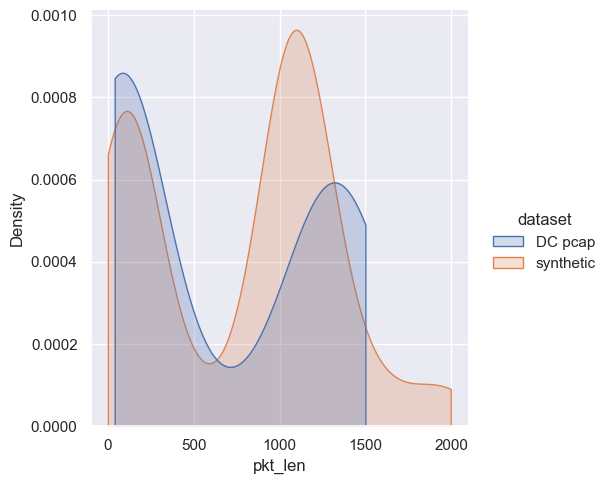

In [24]:
col = "pkt_len"
rf.labs.vis.plot_kde([dataset, syn], col)

**Categorical columns**


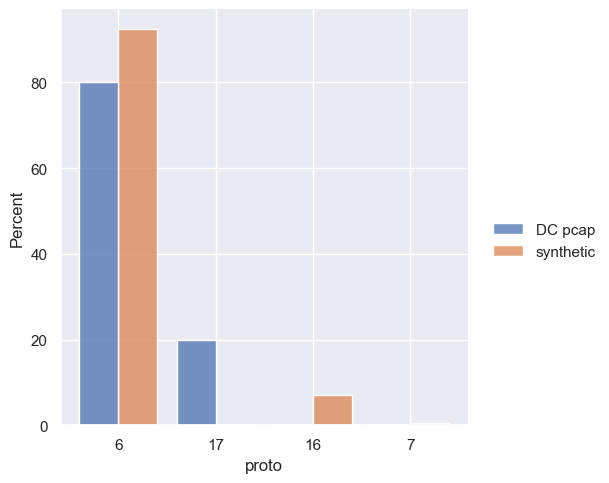

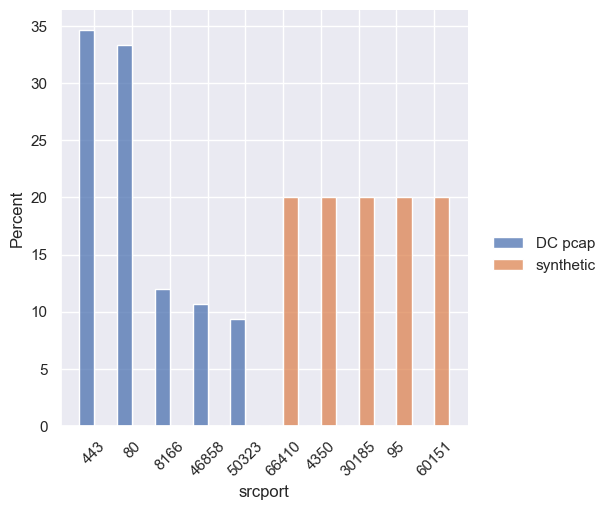

In [25]:
for col in ["proto", "srcport"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=5)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=5)
    rf.labs.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")